# NTT Data Hackathon 2022 (AI in Healthcare)[&#129109;](https://www.techgig.com/codegladiators/NTTDATA 'Link to Hackathon page')
----------------------------------------
## Participant: Atrij Talgery(team ATR21)
### Notebook 1: Model training with diabetes data to predict onset of diabetes.
#### Dataset attribution: 
> **Data source:** <https://www.kaggle.com/code/stpeteishii/predict-diabetes-and-visualize-importance/data>    
  **License:** Not Specified  

> `This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset.`

-------------
This notebook is part of the solution for the hackathon theme: Early Disease Detection. In this notebook, we train a machine learning model (with diabetes incidence data) to predict possibility of a disease condition based on certain health parameters such as: glucose and systolic blood pressure, weight, bmi, etc. The model trained via this notebook is meant to be deployed as part of an application.

In [1]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Read and preprocess dataset

In [2]:
diab_df = pd.read_csv('./Data/diabetes.csv', decimal = ",")
diab_df.replace(to_replace="male", value=1, inplace = True)
diab_df.replace(to_replace="female", value=0, inplace = True)
diab_df.replace(to_replace="Diabetes", value=1, inplace = True)
diab_df.replace(to_replace="No diabetes", value=0, inplace=True)

diab_df.drop("patient_number", axis=1, inplace=True)


## Exploratory Data Analysis

In [3]:
diab_df.shape

(390, 15)

In [4]:
diab_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 390 entries, 0 to 389
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   cholesterol      390 non-null    int64  
 1   glucose          390 non-null    int64  
 2   hdl_chol         390 non-null    int64  
 3   chol_hdl_ratio   390 non-null    float64
 4   age              390 non-null    int64  
 5   gender           390 non-null    int64  
 6   height           390 non-null    int64  
 7   weight           390 non-null    int64  
 8   bmi              390 non-null    float64
 9   systolic_bp      390 non-null    int64  
 10  diastolic_bp     390 non-null    int64  
 11  waist            390 non-null    int64  
 12  hip              390 non-null    int64  
 13  waist_hip_ratio  390 non-null    float64
 14  diabetes         390 non-null    int64  
dtypes: float64(3), int64(12)
memory usage: 45.8 KB


In [5]:
diab_df.describe()   #There are no missing values

,cholesterol,glucose,hdl_chol,chol_hdl_ratio,age,gender,height,weight,bmi,systolic_bp,diastolic_bp,waist,hip,waist_hip_ratio,diabetes
count,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000
mean,207.230769,107.338462,50.266667,4.524615,46.774359,0.415385,65.951282,177.407692,28.775641,137.133333,83.289744,37.869231,42.992308,0.881385,0.153846
std,44.666005,53.798188,17.279069,1.736634,16.435911,0.493421,3.918867,40.407824,6.600915,22.859528,13.498192,5.760947,5.664342,0.073212,0.361265
min,78.000000,48.000000,12.000000,1.500000,19.000000,0.000000,52.000000,99.000000,15.200000,90.000000,48.000000,26.000000,30.000000,0.680000,0.000000
25%,179.000000,81.000000,38.000000,3.200000,34.000000,0.000000,63.000000,150.250000,24.100000,122.000000,75.000000,33.000000,39.000000,0.830000,0.000000
50%,203.000000,90.000000,46.000000,4.200000,44.500000,0.000000,66.000000,173.000000,27.800000,136.000000,82.000000,37.000000,42.000000,0.880000,0.000000
75%,229.000000,107.750000,59.000000,5.400000,60.000000,1.000000,69.000000,200.000000,32.275000,148.000000,90.000000,41.000000,46.000000,0.930000,0.000000
max,443.000000,385.000000,120.000000,19.300000,92.000000,1.000000,76.000000,325.000000,55.800000,250.000000,124.000000,56.000000,64.000000,1.140000,1.000000


In [6]:
diab_df.head()

,cholesterol,glucose,hdl_chol,chol_hdl_ratio,age,gender,height,weight,bmi,systolic_bp,diastolic_bp,waist,hip,waist_hip_ratio,diabetes
0,193,77,49,3.9,19,0,61,119,22.5,118,70,32,38,0.84,0
1,146,79,41,3.6,19,0,60,135,26.4,108,58,33,40,0.83,0
2,217,75,54,4.0,20,0,67,187,29.3,110,72,40,45,0.89,0
3,226,97,70,3.2,20,0,64,114,19.6,122,64,31,39,0.79,0
4,164,91,67,2.4,20,0,70,141,20.2,122,86,32,39,0.82,0


/home/projects/Desktop/projhome/miniconda3/envs/base_ds/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/projects/Desktop/projhome/miniconda3/envs/base_ds/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/projects/Desktop/projhome/miniconda3/envs/base_ds/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='diabetes', ylabel='count'>

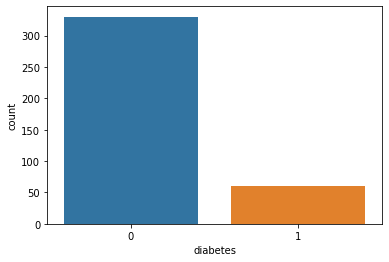

In [7]:
sns.countplot(x = diab_df['diabetes'])

This appears to be an imbalanced dataset. Let us make a pairplot for a quick look at univariate distributions and bivariate scatter.

In [8]:
diab_df['diabetes'].value_counts()

diabetes
0    330
1     60
Name: count, dtype: int64

In [9]:
'''sns.pairplot(diab_df, hue='diabetes')''';

In [10]:
# Problematic observations: >=126mg/dL but indicated as non-diabetic
print("Abnormal Sugar but not diabetic(!)\n",diab_df[(diab_df['glucose']>=126) & (diab_df['diabetes'] == 0)][['glucose','diabetes']])

# Problematic observations: <=99mg/dL but shown as diabetic
print("Normal Sugar but diabetic(!)\n",diab_df[(diab_df['glucose']<=99) & (diab_df['diabetes'] == 1)][['glucose','diabetes']])

Abnormal Sugar but not diabetic(!)
      glucose  diabetes
35       138         0
104      126         0
109      153         0
116      197         0
128      130         0
134      128         0
138      155         0
201      155         0
231      173         0
261      193         0
284      126         0
296      270         0
307      128         0
338      174         0
346      371         0
371      131         0
377      171         0
Normal Sugar but diabetic(!)
      glucose  diabetes
40        60         1
299       90         1
326       90         1
361       71         1


In [11]:
# A total of 17+4=21 observations are problematic. We will drop these.
# Applying DeMorgan's theorem in two steps...
diab_df_clean = diab_df[(diab_df['glucose']<126) | (diab_df['diabetes'] == 1)]
diab_df_clean = diab_df_clean[(diab_df_clean['glucose']>99) | (diab_df_clean['diabetes'] == 0)]
diab_df_clean.shape

(369, 15)

## Feature Selection
We have already encoded the data while reading it in, hence there is no separate data encoding step. We will instead fit a random forest classifier only for the purpose of understanding feature importance. 

In [12]:
from sklearn.ensemble import RandomForestClassifier

X = diab_df_clean.drop(['diabetes'], axis = 1)
y = diab_df_clean['diabetes']

In [13]:
X.head()

,cholesterol,glucose,hdl_chol,chol_hdl_ratio,age,gender,height,weight,bmi,systolic_bp,diastolic_bp,waist,hip,waist_hip_ratio
0,193,77,49,3.9,19,0,61,119,22.5,118,70,32,38,0.84
1,146,79,41,3.6,19,0,60,135,26.4,108,58,33,40,0.83
2,217,75,54,4.0,20,0,67,187,29.3,110,72,40,45,0.89
3,226,97,70,3.2,20,0,64,114,19.6,122,64,31,39,0.79
4,164,91,67,2.4,20,0,70,141,20.2,122,86,32,39,0.82


In [14]:
y.head().values

array([0, 0, 0, 0, 0])

In [15]:
clf = RandomForestClassifier(criterion = 'entropy',min_samples_split = 10)  #Rest all parameters at defaults
clf.fit(X, y.values)

RandomForestClassifier(criterion='entropy', min_samples_split=10)

In [16]:
feat_imp = pd.Series(clf.feature_importances_, index = list(X)).sort_values(ascending = False)
print(list(feat_imp.index))

['glucose', 'age', 'chol_hdl_ratio', 'systolic_bp', 'bmi', 'cholesterol', 'hdl_chol', 'waist', 'weight', 'hip', 'waist_hip_ratio', 'diastolic_bp', 'height', 'gender']


with gini ['glucose', 'age', 'systolic_bp', 'cholesterol', 'chol_hdl_ratio', 'bmi', 'weight', 'waist_hip_ratio', 'waist', 'hdl_chol', 'hip', 'diastolic_bp', 'height', 'gender']   
**We use the entropy criterion as it is much more suitable for imbalanced datasets such as this one.**

/home/projects/Desktop/projhome/miniconda3/envs/base_ds/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/projects/Desktop/projhome/miniconda3/envs/base_ds/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/projects/Desktop/projhome/miniconda3/envs/base_ds/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


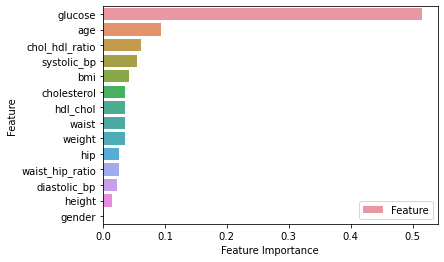

In [17]:
sns.barplot(x = feat_imp, y = feat_imp.index, label = 'Feature')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.legend()


By far, glucose is the most important indicator of diabetes. Age and all other factors come a distant second.  Now we will use the top 6 factors for creating our actual random forest classifier.  Before that, let us take a closer look at the feature `glucose` and the target label.

/home/projects/Desktop/projhome/miniconda3/envs/base_ds/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/projects/Desktop/projhome/miniconda3/envs/base_ds/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/projects/Desktop/projhome/miniconda3/envs/base_ds/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='diabetes', ylabel='glucose'>

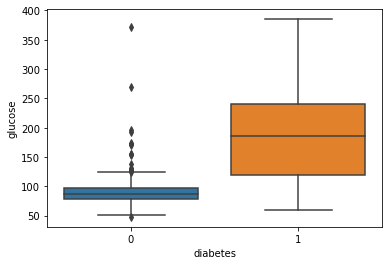

In [18]:
sns.boxplot(data = diab_df, x = 'diabetes', y = 'glucose')

The outliers are a cause for concern.  Are there any mislabeled observations?  One would think so.   
Refer https://www.cdc.gov/diabetes/images/basics/CDC_Diabetes_Social_Ad_Concept_A2_Facebook.png

We need to fix these mislabeled observations. Not doing so might adversely impact our classifier.

In [19]:
#Let us select the top 8 features. 
# Note: Cholesterol, chol_hdl_ratio and hdl_chol are multicollinear. We pick the first two.
# top_n_feat = 8
feat_sel = ['glucose', 'age', 'systolic_bp', 'chol_hdl_ratio', 'bmi', 'cholesterol','waist', 'weight']
# feat_sel = list(feat_imp.index[:top_n_feat])
X_sel = X[feat_sel]
X_sel.head()

,glucose,age,systolic_bp,chol_hdl_ratio,bmi,cholesterol,waist,weight
0,77,19,118,3.9,22.5,193,32,119
1,79,19,108,3.6,26.4,146,33,135
2,75,20,110,4.0,29.3,217,40,187
3,97,20,122,3.2,19.6,226,31,114
4,91,20,122,2.4,20.2,164,32,141


### Model Fitting and Evaluation

In [20]:
from sklearn.model_selection import train_test_split
X_sel_train, X_sel_test, y_train, y_test = train_test_split(X_sel, y, test_size = 0.33, 
                                                            random_state = 1, 
                                                            stratify = y
                                                           )

#from sklearn.ensemble import GradientBoostingClassifier
#clf1 = GradientBoostingClassifier()
clf1 = RandomForestClassifier(criterion = 'entropy', min_samples_split = 10)
clf1.fit(X_sel_train, y_train.values)

RandomForestClassifier(criterion='entropy', min_samples_split=10)

In [21]:
import pickle
pickle.dump(clf1, open("diab_model_rf.pkl","wb"))
#reactivate this cell as and when needed.

**Confusion Matrix directly from estimator**. This confusion matrix is based on a fixed classifier threshold of 0.5.  For a precision-recall tradeoff -- which might be necessary in imbalanced datasets -- this may not be the preferred method.

Text(0.5, 1.0, 'Confusion Matrix')

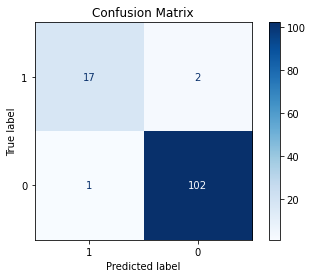

In [22]:
from sklearn import metrics
#plot confusion matrix
disp = metrics.ConfusionMatrixDisplay.from_estimator(clf1, X_sel_test, y_test, labels = (1,0), normalize = None, cmap='Blues')
disp.ax_.grid(False)
disp.ax_.set_title('Confusion Matrix')


We will look at how to get classifier predictions based on an **adjustable proabability threshold** that will help us with precision-recall tradeoff.

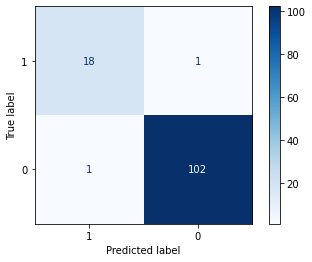

In [23]:
adj_thresh = True # set to True if you want adjustable threshold
if adj_thresh:
    clf_thresh = 0.4 # lower value improves recall but reduces precision and vice-versa
    preds = [{True:1,False:0}[truth] for truth in (clf1.predict_proba(X_sel_test)[:,1] >= clf_thresh)]
else:
    preds = clf1.predict(X_sel_test)

metrics.ConfusionMatrixDisplay.from_predictions(y_test, preds,labels = (1,0), normalize = None, cmap='Blues')

Text(0.5, 1.0, 'ROC Curve')

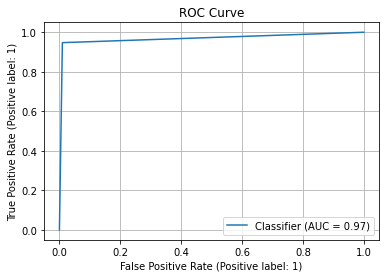

In [25]:
#from sklearn.metrics import plot_roc_curve
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
#disp = RocCurveDisplay.from_estimator(clf1, X_sel_test, y_test)
disp = RocCurveDisplay.from_predictions(y_test, preds)
disp.ax_.grid(True)
disp.ax_.set_title("ROC Curve")

F1 Score: 0.95


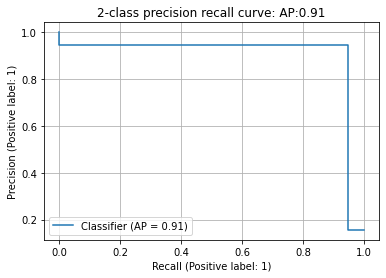

In [27]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import  f1_score

y_score = clf1.predict_proba(X_sel_test)
#average_precision = average_precision_score(y_test, y_score[:,1])
average_precision = average_precision_score(y_test, preds)

#disp = metrics.PrecisionRecallDisplay.from_estimator(clf1, X_sel_test, y_test)
disp = metrics.PrecisionRecallDisplay.from_predictions(y_test, preds)
disp.ax_.set_title('2-class precision recall curve: ' 'AP:{0:0.2f}'.format(average_precision))
disp.ax_.grid(True)

print(f'F1 Score: {f1_score(y_test, preds):0.2f}')

|| END ||
------------------------